In [9]:
import sys

sys.path.append('models')

import torch
from torch.distributions import Distribution, Normal, constraints
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as dist
import torch

from models.lightcurves import LightCurve
from interpolate_lcs import ugrizy_to_numbers
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.preprocessing import StandardScaler

# from sbi import utils as utils
# from sbi.utils import process_prior
# from sbi import inference as Inference
# from scipy import optimize, stats

# Note that we are lazily using the CPU, but this is faster w/ a GPU
if torch.cuda.is_available(): device = 'mps'
else: device = 'cpu'
print(f'device is {device}')
torch.set_default_dtype(torch.float32)

# matplotlib formatting
import matplotlib as mpl
plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

device is cpu


# Import Data

In [2]:
# Import the LCs
lcs = np.load('data/full_lcs.npz', allow_pickle=True)['lcs']
print(lcs.shape)

(66549,)


In [8]:
# Import the LCs
lcs = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
print(lcs.shape)
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
lcs.shape, len([lc for lc in lcs if np.mean(lc.snrs) > 3])

(32643,)


((32643,), 12525)

In [61]:
def ab_mag_to_flux(AB_mag: np.ndarray) -> np.ndarray:
    """Convert AB magnitude to flux in units of mJy"""
    return 10**((AB_mag - 8.9) / -2.5) * 1000

mags_interped = np.array([lc.mags_interped for lc in lcs if np.mean(lc.snrs) > 3])
mags_interped.shape
# fluxes = ab_mag_to_flux(mags)
# fluxes.shape

(12525, 600)

In [48]:
max_length = max(len(lc.mags) for lc in lcs)

# Create an array of nans with the shape of (number of sequences, max_length)
mags = np.full((len(lcs), max_length), np.nan)

# Fill in the actual values into the array, leaving nans for missing data
for i, lc in enumerate(lcs):
    length = len(lc.mags)
    mags[i, :length] = lc.mags

In [31]:
np.max(mags)

nan

In [39]:
bad_gp_mask = np.nanmin(mags[:, ::6], axis=1) > 25
bad_gp_mask

array([False, False, False, ..., False, False,  True])

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10205/1556575603.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(mags[bad_gp_mask][:100, ::6])


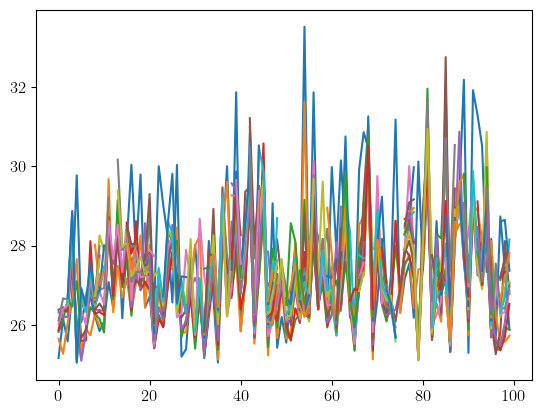

In [44]:
plt.plot(mags[bad_gp_mask][:100, ::6])
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10205/1173829769.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 6, figsize=(20, 4))


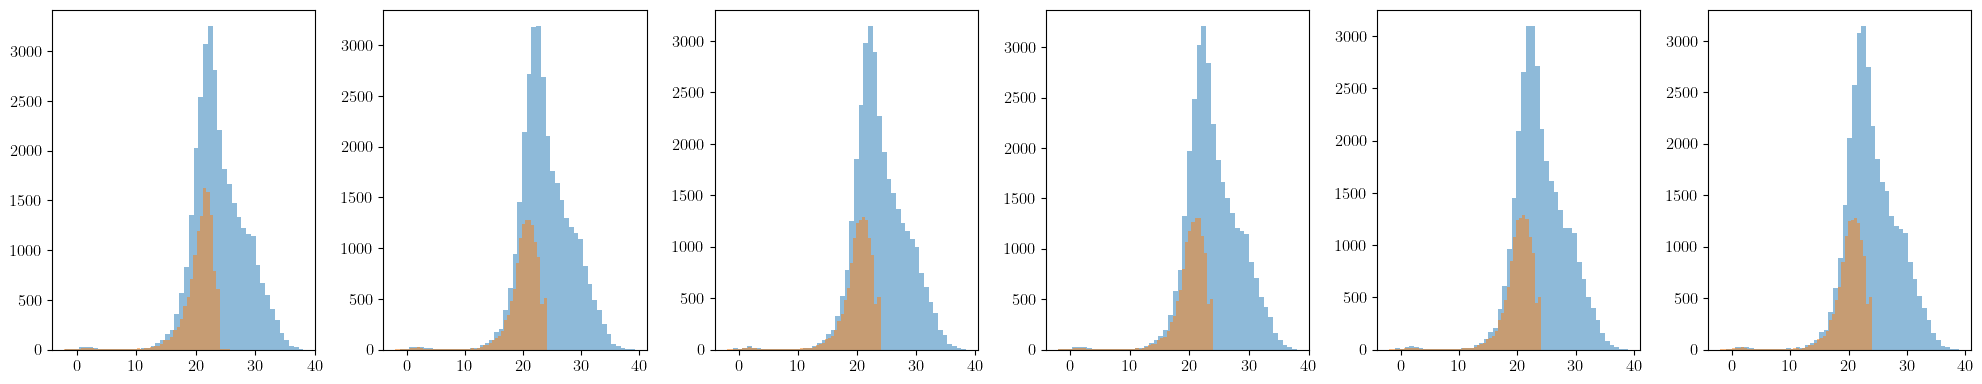

In [62]:
fig, axes = plt.subplots(1, 6, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.hist(np.nanmin(mags[:, ::6 + i], axis=1), bins=50, alpha=0.5)
    ax.hist(np.nanmin(mags_interped[:, ::6 + i], axis=1), bins=50, alpha=0.5)
plt.tight_layout()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10205/2431827891.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(test_X[(test_X < -3) & (test_X > -3.04)], bins=50)


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([-3.02614698, -3.02579382, -3.02544066, -3.02508749, -3.02473433,
        -3.02438117, -3.02402801, -3.02367485, -3.02332168, -3.02296852,
        -3.02261536, -3.0222622 , -3.02190903, -3.02155587, -3.02120271,
        -3.02084955, -3.02049639, -3.02014322, -3.01979006, -3.0194369 ,
        -3.01908374, -3.01873057, -3.01837741, -3.01802425, -3.01767109,
        -3.01731793, -3.01696476, -3.0166116 , -3.01625844, -3.01590528,
        -3.01555211, -3.01519895, -3.01484579, -3.01449263, -3.01413946,
        -3.0137863 , -3.01343314, -3.01307998, -3.01272682, -3.01237365,
        -3.01202049, -3.01166733, -3.01131417, -3.010961  , -3.01060784,
        -3.01025468, -3.00990152, -3.00954836, -3.00919519, -3.00884203,
        -3.00848887]),
 <BarContainer object

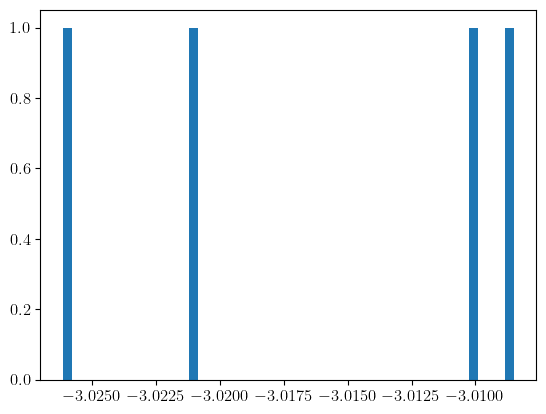

In [54]:
test_X = np.log10(ab_mag_to_flux(mags)[:,500])
plt.hist(test_X[(test_X < -3) & (test_X > -3.04)], bins=50)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8897/3977533601.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(fluxes[:, ::6][10])


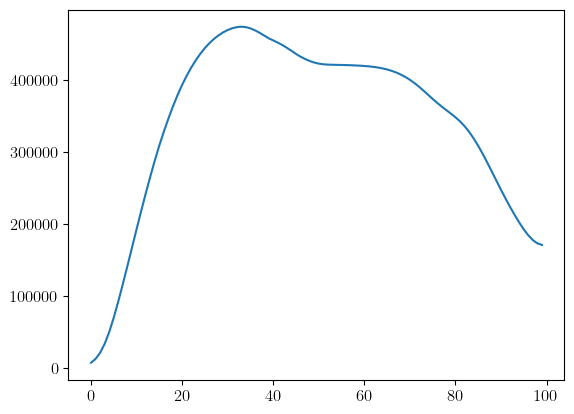

In [49]:
fluxes = ab_mag_to_flux(mags)
fluxes[:, ::6].shape
plt.plot(fluxes[:, ::6][10])

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8897/1571932137.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(mags[:, 500][~bad_bands], bins=50)


(array([ 1.,  1.,  2.,  8.,  7.,  8., 15., 16., 10.,  7., 10.,  8.,  9.,
        11.,  3.,  3.,  4.,  7.,  1.,  4.,  4.,  2.,  5.,  5.,  7.,  5.,
        10.,  7., 11., 22., 24., 29., 24., 38., 36., 49., 43., 37., 57.,
        43., 45., 42., 40., 38., 33., 30., 27., 22., 24., 12.]),
 array([-9.78439600e-01, -4.87783479e-01,  2.87264132e-03,  4.93528762e-01,
         9.84184882e-01,  1.47484100e+00,  1.96549712e+00,  2.45615324e+00,
         2.94680936e+00,  3.43746548e+00,  3.92812160e+00,  4.41877773e+00,
         4.90943385e+00,  5.40008997e+00,  5.89074609e+00,  6.38140221e+00,
         6.87205833e+00,  7.36271445e+00,  7.85337057e+00,  8.34402669e+00,
         8.83468281e+00,  9.32533893e+00,  9.81599505e+00,  1.03066512e+01,
         1.07973073e+01,  1.12879634e+01,  1.17786195e+01,  1.22692757e+01,
         1.27599318e+01,  1.32505879e+01,  1.37412440e+01,  1.42319001e+01,
         1.47225563e+01,  1.52132124e+01,  1.57038685e+01,  1.61945246e+01,
         1.66851807e+01,  1.7175

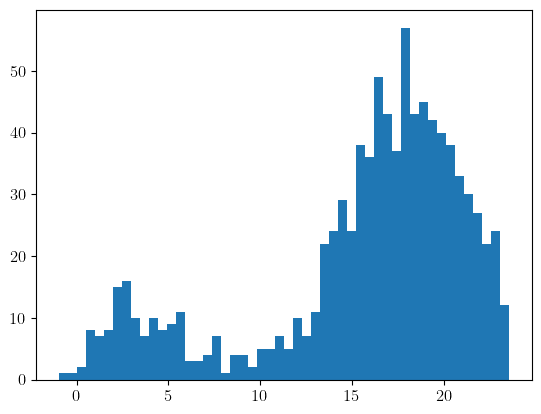

In [60]:
bad_bands = fluxes[:, 10] < 0.001
plt.hist(mags[:, 500][~bad_bands], bins=50)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8897/39633687.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(mags[((test_X < -3) & (test_X > -3.04))])


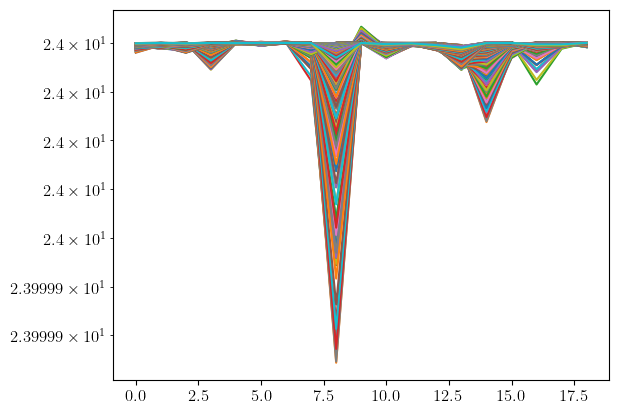

In [40]:
plt.plot(mags[((test_X < -3) & (test_X > -3.04))])
plt.yscale('log')

In [38]:
mags[~((test_X < -3) & (test_X > -3.04))].shape

(981, 100)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8897/3397026606.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(mags[~((test_X < -3) & (test_X > -3.04))][:, ::6])


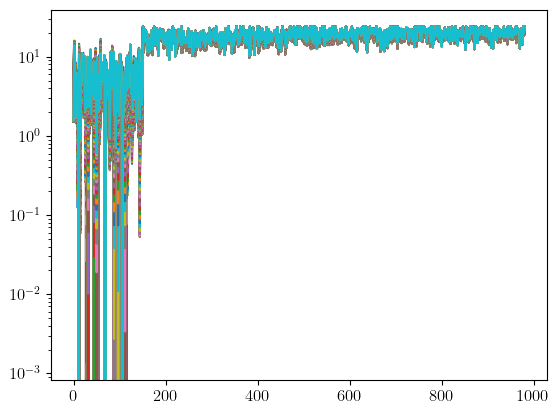

In [36]:
plt.plot(mags[~((test_X < -3) & (test_X > -3.04))][:, ::6])
plt.yscale('log')

In [11]:
import pickle
with open('data/full_encoded_lcs.pkl', 'rb') as f:
    encoded_lcs, lcs = pickle.load(f)